In [1]:
import numpy as np
import sys
sys.path.append('../../')
import do_mpc
from casadi import *
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
def control(x_i,i,x,y):
    model_type='discrete'
    model=do_mpc.model.Model(model_type)
    x_0=x_i
    J=1000
    La=1
    Lb=1
    m=200
    Cy=0.1
    t_s=0.1 #sample time
    N=50
    k=0.01
    R=100
    #state variables
    ψ=model.set_variable(var_type='_x',var_name='ψ',shape=(1,1))
    xc=model.set_variable(var_type='_x',var_name='xc',shape=(1,1))
    yc=model.set_variable(var_type='_x',var_name='yc',shape=(1,1))
    v=model.set_variable(var_type='_x',var_name='v',shape=(1,1))
    θ=model.set_variable(var_type='_x',var_name='θ',shape=(1,1))
    ϕ=model.set_variable(var_type='_x',var_name='ϕ',shape=(1,1))
    δ=model.set_variable(var_type='_x',var_name='δ',shape=(1,1))
    a_s=model.set_variable(var_type='_x',var_name='a_s',shape=(1,1))
    w_s=model.set_variable(var_type='_x',var_name='w_s',shape=(1,1))
    Fyf=Cy*(δ-(La*ϕ)/v)
    Fyr=(Cy*Lb*ϕ)/v
    #control inputs
    a=model.set_variable(var_type='_u',var_name='a',shape=(1,1))
    ω=model.set_variable(var_type='_u',var_name='ω',shape=(1,1))
    model.set_expression(expr_name='cost', expr=sum1((xc-R+R*np.cos(ψ))**2+(yc-R*np.sin(ψ))**2
                                                     +a_s**2+w_s**2+θ**2))
    state_now=vertcat(ψ,xc, yc, v, θ, ϕ, δ,a_s,w_s)
    B=t_s*vertcat(k,v*np.cos(θ), v*np.sin(θ), a* np.cos(δ)-(2.0/m)*Fyf*np.sin(δ), ϕ,
                  (1.0/J)*(La*(m*a*np.sin(δ)+2*Fyf*np.cos(δ))-2*Lb*Fyr), ω,(1/t_s)*(a-a_s),(1/t_s)*(ω-w_s))
    state_next=state_now + B
    model.set_rhs('ψ',state_next[0])
    model.set_rhs('xc',state_next[1])
    model.set_rhs('yc',state_next[2])
    model.set_rhs('v',state_next[3])
    model.set_rhs('θ',state_next[4])
    model.set_rhs('ϕ',state_next[5])
    model.set_rhs('δ',state_next[6])
    model.set_rhs('a_s',state_next[7])
    model.set_rhs('w_s',state_next[8])
    model.setup()
    mpc=do_mpc.controller.MPC(model)
    setup_mpc = {
        'n_horizon': N,
        't_step': t_s,
        'n_robust': 0,
        'state_discretization':'discrete',
        'store_full_solution': True,
    }
    mpc.set_param(**setup_mpc)
    mterm = model.aux['cost']
    lterm = model.aux['cost']
    mpc.set_objective(mterm=mterm, lterm=lterm)
    mpc.set_rterm(a=0.1)
    mpc.set_rterm(ω=0.1)
    # 'tube' from path planning
    #mpc.bounds['lower','_x','xc']=x_i[0]-1e-19
    mpc.bounds['lower','_x','yc']=-R-1e-1
    mpc.bounds['lower','_x','v']=0 #max reverse speed in m/s
    mpc.bounds['lower','_x','θ']=-np.pi-1e-2
    #mpc.bounds['lower','_x','ϕ']=-50
    mpc.bounds['lower','_x','δ']=-50
    #mpc.bounds['upper','_x','xc']=target+5
    mpc.bounds['upper','_x','yc']=R+1e-2
    mpc.bounds['upper','_x','v']=20 #max forward speed in m/s
    mpc.bounds['upper','_x','θ']=np.pi + 1e-2
    #mpc.bounds['upper','_x','ϕ']=50
    mpc.bounds['upper','_x','δ']=50
    mpc.bounds['lower','_u','a']=-10
    mpc.bounds['lower','_u','ω']=-10
    mpc.bounds['upper','_u','a']=10
    mpc.bounds['upper','_u','ω']=10
    mpc.bounds['lower','_x','a_s']=-10
    mpc.bounds['lower','_x','w_s']=-10
    mpc.bounds['upper','_x','a_s']=10
    mpc.bounds['upper','_x','w_s']=10
    mpc.setup()
    #estimator=do_mpc.estimator.StateFeedback(model)
    simulator = do_mpc.simulator.Simulator(model)
    simulator.set_param(t_step = t_s)
    simulator.setup()
    mpc.x0 = x_0
    simulator.x0 = x_0
    mpc.u0['a']=x_0[-2]
    mpc.u0['ω']=x_0[-1]
    mpc.set_initial_guess()
    '''
    if i==100:
        mpl.rcParams['font.size'] = 18
        mpl.rcParams['lines.linewidth'] = 3
        mpl.rcParams['axes.grid'] = True
        mpc_graphics=do_mpc.graphics.Graphics(mpc.data)
        simulator_graphics=do_mpc.graphics.Graphics(simulator.data)
        fig, ax = plt.subplots(7, sharex=True, figsize=(16,9))
        fig.align_ylabels()
        for g in [simulator_graphics,mpc_graphics]:
            g.add_line(var_type='_x',var_name='xc',axis=ax[0])
            g.add_line(var_type='_x',var_name='yc',axis=ax[1])
            g.add_line(var_type='_x',var_name='v',axis=ax[2])
            g.add_line(var_type='_u',var_name='a',axis=ax[3])
            g.add_line(var_type='_u',var_name='ω',axis=ax[4])
            g.add_line(var_type='_x',var_name='θ',axis=ax[5])
            g.add_line(var_type='_x',var_name='ψ',axis=ax[6])
        ax[0].set_ylabel('xc')
        ax[1].set_ylabel('yc')
        ax[2].set_ylabel('v')
        ax[3].set_ylabel('a')
        ax[4].set_ylabel('ω')
        ax[5].set_ylabel('θ')
        ax[6].set_ylabel('ψ')
        ax[6].set_xlabel('t')'''
    mpc.reset_history()
    N_u=N
    for j in range(N_u):
        u0=mpc.make_step(x_0)
        x_0=simulator.make_step(u0)
        #if simulator.data['_x','xc',-1][-1]>=target:
         #   break
        #x_0=estimator.make_step(y_0)
    '''
    if i==100:
        mpc_graphics.plot_predictions(t_ind=0)
        simulator_graphics.plot_results()
        simulator_graphics.reset_axes()'''
    x=np.array(vertcat(x,simulator.data['_x','xc',-1]))
    y=np.array(vertcat(y,simulator.data['_x','yc',-1]))
    #z=vertcat(z,simulator.data['_x','θ',-1])
    if x_0[0]>=np.pi:
        return x,y,x_0
    else:
        #x_0=simulator.data['_x'][-1]
        return control(x_0,i+1,x,y)

In [4]:
%%capture [--no-stderr]
x_0=np.array([[0],[0],[0],[0.001],[np.pi/2],[0],[0],[0],[0]])
#initial condition on theta
x=np.zeros((1,1))
y=np.zeros((1,1))
(xx,yy,x_0)=control(x_0,0,x,y)

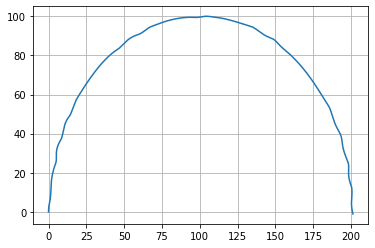

In [5]:
plt.plot(xx,yy)
plt.grid()
plt.show()